<a href="https://colab.research.google.com/github/Liverson-Al/Exam/blob/main/Covid_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

url_new = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
url_death = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
url_vaccine = 'https://raw.githubusercontent.com/govex/COVID-19/master/data_tables/vaccine_data/global_data/time_series_covid19_vaccine_doses_admin_global.csv'
df_new = pd.read_csv(url_new)
df_death = pd.read_csv(url_death)
df_vaccine = pd.read_csv(url_vaccine)

df_new=df_new.drop(labels=["Lat","Long","Province/State"], inplace=False, axis=1)
df_death=df_death.drop(labels=["Lat","Long","Province/State"], inplace=False, axis=1)
df_vaccine=df_vaccine.drop(labels=["UID", "Lat","Long_", "Combined_Key", "Province_State", "Admin2", "FIPS", "code3", "iso3", "iso2", "Population"], inplace=False, axis=1)

i=1
columns=df_new.columns
while(i<len(df_new.index)):
  if (df_new[columns[0]][i]==df_new[columns[0]][i-1]):
    country_name=df_new["Country/Region"][i-1]
    country_index=i-1
    while(df_new[columns[0]][i]==country_name):
      for j in range(1,len(columns)):
        df_new[columns[j]][country_index]+=df_new[columns[j]][i]
      i+=1
  i+=1

i=1
columns=df_death.columns
while(i<len(df_death.index)):
  if (df_death[columns[0]][i]==df_death[columns[0]][i-1]):
    country_name=df_death["Country/Region"][i-1]
    country_index=i-1
    while(df_death[columns[0]][i]==country_name):
      for j in range(1,len(columns)):
        df_death[columns[j]][country_index]+=df_death[columns[j]][i]
      i+=1
  i+=1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# **ДИНАМИКА НОВЫХ СЛУЧАЕВ**

Enter country: Ukraine
Show statistics for all time? (y/n): y


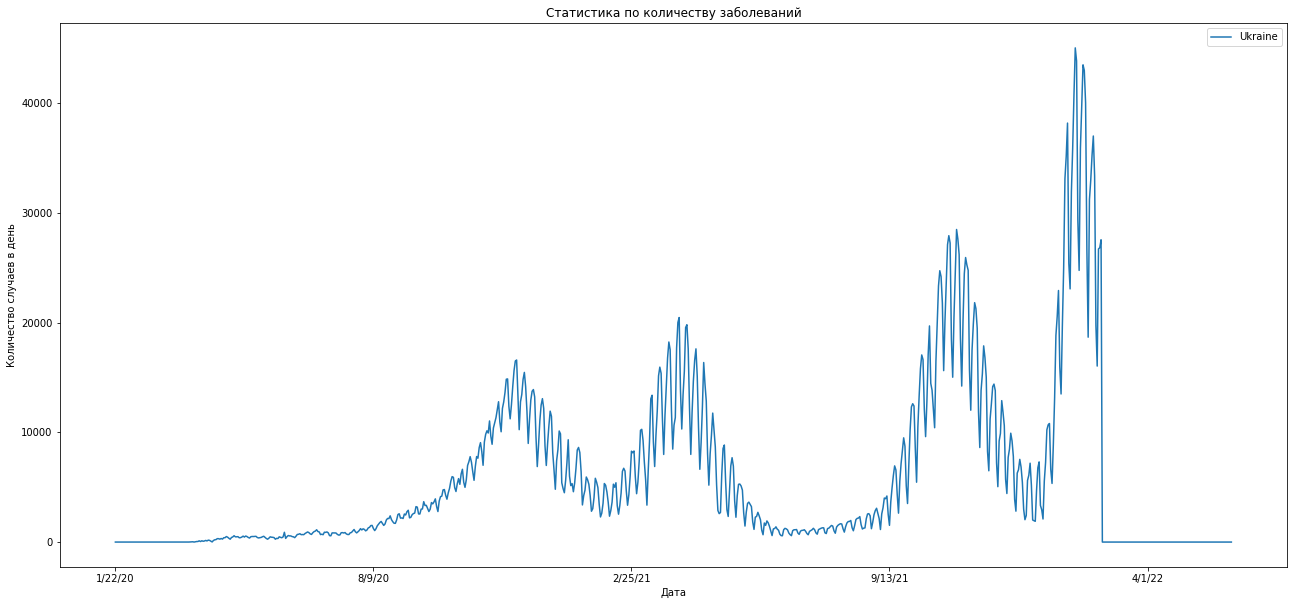

In [67]:
country = input("Enter country: ")
date_check = str.lower(input("Show statistics for all time? (y/n): "))

if (date_check == "n"):
   date1 = str(input("Enter first date (MM/DD/YY): "))
   date2 = str(input("Enter second date (MM/DD/YY): "))
else:
  date1="1/22/20"
  date2=df_new.columns[-1]


df_new_copy=df_new.copy(deep=True)

country_row_new = df_new_copy.loc[(df_new_copy["Country/Region"] == country)]
if (country_row_new.shape[0]>1):
  country_row_new=country_row_new[:][:1]

country_row_new=country_row_new.drop(labels=["Country/Region"], inplace=False, axis=1)

country_row_new=country_row_new.transpose()
country_row_new=country_row_new.rename(columns={country_row_new.columns[0] : country})
shape=country_row_new.shape
i=shape[0]-1
while (i>1):
  country_row_new[country][i]-=country_row_new[country][i-1]
  i-=1
country_row_new=country_row_new[date1:date2]
country_row_new=country_row_new.rename(columns={country_row_new.columns[0] : country})

country_row_new.plot(figsize=(22,10),xlabel="Дата",ylabel="Количество случаев в день",title="Статистика по количеству заболеваний")


# **ДЛИНА КАЖДОЙ ВОЛНЫ**

In [68]:
from scipy.signal import find_peaks
from scipy.signal import argrelextrema

df = pd.read_csv("https://storage.googleapis.com/covid19-open-data/v3/epidemiology.csv")
df = df.set_index('date')

In [72]:
def waves(country):
  data = df[(df['location_key'] == country) & (df['new_confirmed'].notna())]['new_confirmed']

  peaks, _ = find_peaks(data,width=1,distance = 60) # индексы локальных максимумов
  ilocs_min = argrelextrema(data[data != 0].values, np.less_equal,order=5)[0] # индексы локальных минимумов

  bottoms = data[ilocs_min] # данные локальных минимумов
  bottoms = bottoms.drop(bottoms[(bottoms == 0)].index[: bottoms[(bottoms == 0)].index.shape[0]-1]) # удаляем нулевые элементы, если их больше одного

  
  tops = data[peaks] # данные локальных максимумов

  i=0
  j=0
  bottoms_new=[]
  bottoms_new_index=[]
  while(i<len(ilocs_min)):
    ilocs_min_buff=[]
    while(ilocs_min[i]<peaks[j]):
      ilocs_min_buff.append(ilocs_min[i])
      i+=1
      if (i>=len(ilocs_min)):
        break
    buff_data=data[ilocs_min_buff]
    if (buff_data.empty!=True):
      r=0
      bottoms_new.append(buff_data.min())
      for p in buff_data:
        if (p==bottoms_new[-1]):
          bottoms_new_index.append(ilocs_min_buff[r])
          break
        r+=1
    j+=1
  
  i=1
  j=0
  peaks_new=[]
  peaks_new_index=[]
  while(j<len(peaks)):
    peaks_max_buff=[]
    while(ilocs_min[i]>peaks[j]):
      peaks_max_buff.append(peaks[j])
      j+=1
      if (j>=len(peaks)):
        break
    buff_data=data[peaks_max_buff]
    if (buff_data.empty!=True):
      r=0
      peaks_new.append(buff_data.max())
      for p in buff_data:
        if (p==peaks_new[-1]):
          peaks_new_index.append(peaks_max_buff[r])
          break
        r+=1
    i+=1
    if(i>=len(ilocs_min)):
      break

  if (tops[-1] > bottoms[-1]):
    peaks_new.append(tops[-1])
    peaks_new_index.append(peaks[-1])
  
  

  waves_down=[]
  waves_up=[]
  waves_length = []

  for i in range(len(bottoms_new_index)-1):
    waves_length.append(bottoms_new_index[i+1]-bottoms_new_index[i])
  for i in range(len(bottoms_new_index)-1):
    waves_up.append(peaks_new_index[i]-bottoms_new_index[i])

  for i in range(len(peaks_new_index)-1):
    waves_down.append(bottoms_new_index[i+1]-peaks_new_index[i])

  plt.subplots(figsize=(22, 10))
  data.plot()
  plt.plot(peaks_new_index, peaks_new, "v") #локальные максимумы
  plt.plot(bottoms_new_index,bottoms_new,"^") #локальные минимумы
  plt.title(country, fontsize=10)
  plt.show()

  print("Длина спуска волны")
  print(waves_down) 
  print("Длина подъёма волны")
  print(waves_up)
  print("Длина волн")
  print(waves_length)

Enter country: 
US


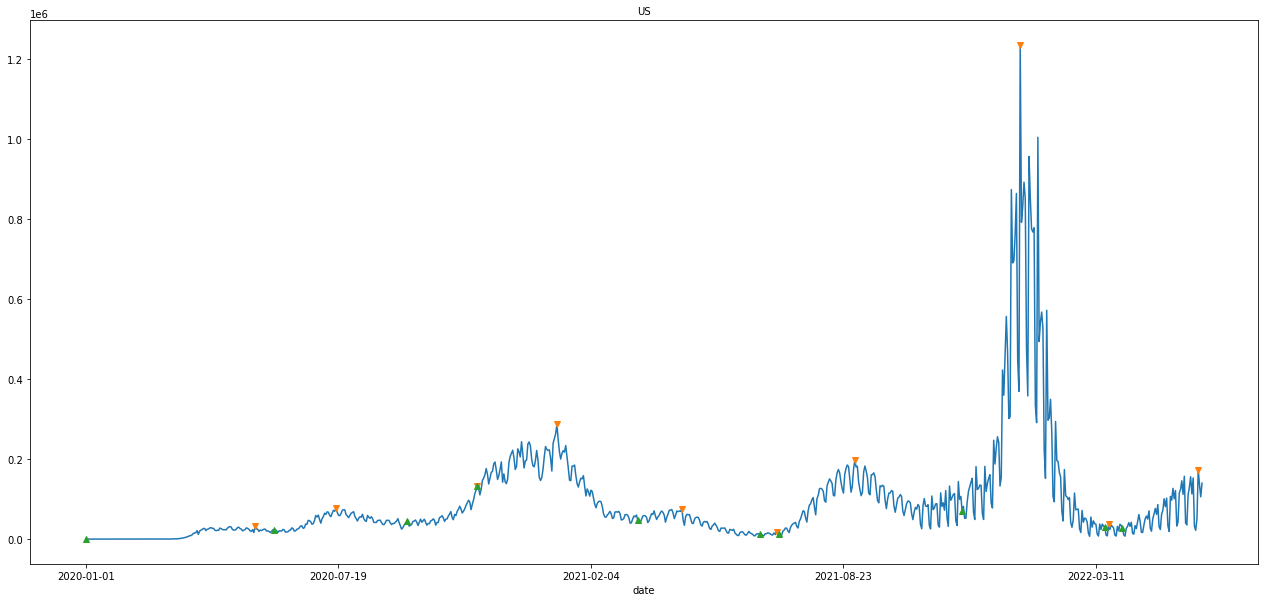

Длина спуска волны
[15, 56, 0, 64, 62, 2, 85, 67, 11]
Длина подъёма волны
[134, 49, 56, 63, 35, 13, 60, 46, 3]
Длина волн
[149, 105, 56, 127, 97, 15, 145, 113, 14]


In [74]:
print("Enter country: ")
country = input()
waves(country)

# **ДИНАМИКА СМЕРТНОСТИ**

Enter country: Russia
Show statistics for all time? (y/n): n
Enter first date (MM/DD/YY): 1/1/22
Enter second date (MM/DD/YY): 6/5/22


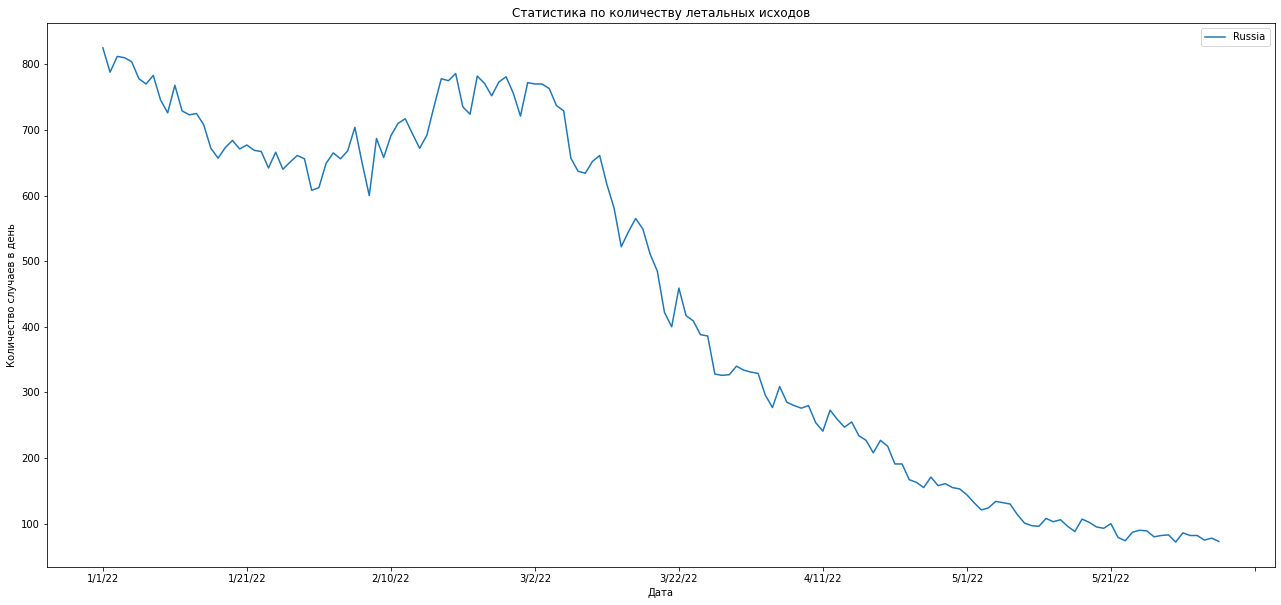

In [75]:
country = input("Enter country: ")
date_check = str.lower(input("Show statistics for all time? (y/n): "))

if (date_check == "n"):
   date1 = str(input("Enter first date (MM/DD/YY): "))
   date2 = str(input("Enter second date (MM/DD/YY): "))
else:
  date1="1/22/20"
  date2=df_death.columns[-1]

df_death_copy=df_death.copy(deep=True)
country_row_new = df_death_copy.loc[(df_death_copy["Country/Region"] == country)]
if (country_row_new.shape[0]>1):
  country_row_new=country_row_new[:][:1]
country_row_new=country_row_new.drop(labels=["Country/Region"], inplace=False, axis=1)

country_row_new=country_row_new.transpose()
country_row_new=country_row_new.rename(columns={country_row_new.columns[0] : country})
shape=country_row_new.shape
i=shape[0]-1
while (i>1):
  country_row_new[country][i]-=country_row_new[country][i-1]
  i-=1
country_row_new=country_row_new[date1:date2]
country_row_new=country_row_new.rename(columns={country_row_new.columns[0] : country})

country_row_new.plot(figsize=(22,10),xlabel="Дата",ylabel="Количество случаев в день",title="Статистика по количеству летальных исходов")

# **ПРОВЕРКА ГИПОТЕЗ: 1) СНИЖАЛОСЬ ЛИ ЧИСЛО НОВЫХ СЛУЧАЕВ С РОСТОМ ВАКЦИНАЦИИ; 2) СНИЖАЛОСЬ ЛИ ЧИСЛО СМЕРТЕЙ С РОСТОМ ВАКЦИНАЦИИ**

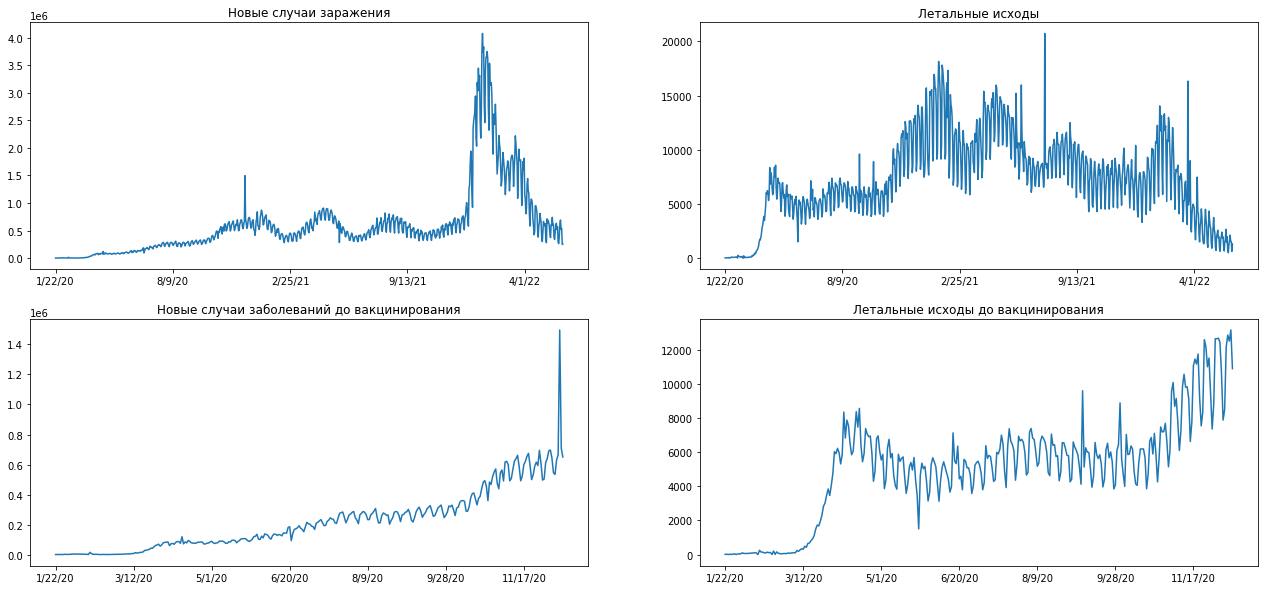

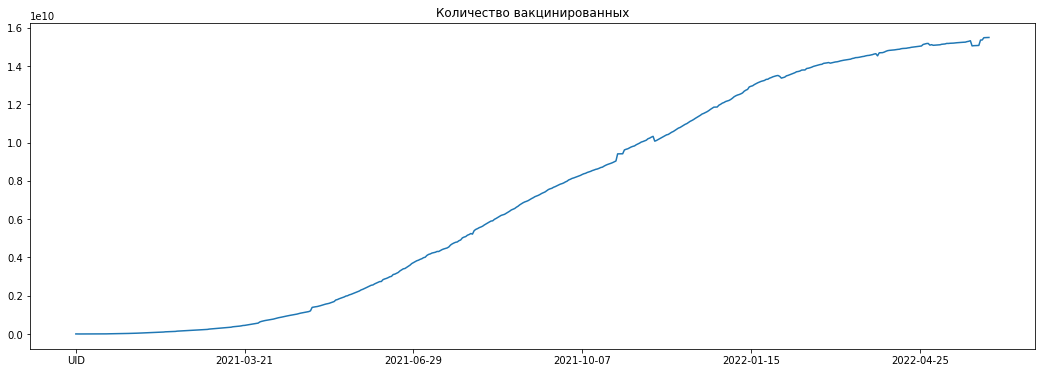

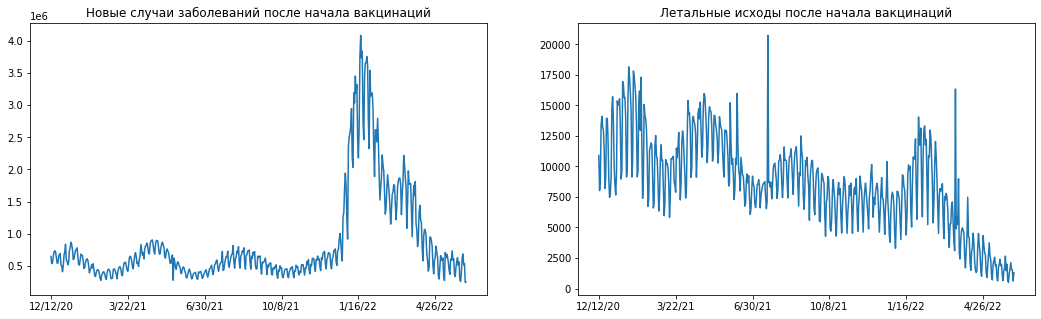

In [77]:

df_new = pd.read_csv(url_new)
df_death = pd.read_csv(url_death)
df_vaccine = pd.read_csv(url_vaccine)

df_new=df_new.drop(labels=["Lat","Long", "Province/State"], inplace=False, axis=1)
df_death=df_death.drop(labels=["Lat","Long", "Province/State"], inplace=False, axis=1)
df_vaccine=df_vaccine.drop(labels=["Lat","Long_", "Combined_Key", "Province_State", "Admin2", "FIPS", "code3", "iso3", "iso2", "Population"], inplace=False, axis=1)
del df_death["Country/Region"]
del df_new["Country/Region"]     
del df_vaccine["Country_Region"]

news = df_new.sum()
deaths = df_death.sum()
vaccines = df_vaccine.sum()

s = len(news)
cols = news.index 
while(s>2):
  news[cols[s-1]] -= news[cols[s-2]]
  s-=1

s = len(deaths)
cols = deaths.index 
while(s>2):
  deaths[cols[s-1]] -= deaths[cols[s-2]]
  s-=1

date1="1/22/20"
date2="12/12/20"
date_end = cols[-1]



news_before=news[date1:date2]
deaths_before = deaths[date1:date2]
news_after = news[date2:date_end]
deaths_after = deaths[date2:date_end]

plt.figure(figsize=(22, 10))
plt.subplot(2, 2, 1)
news.plot(title = "Новые случаи заражения")
plt.subplot(2, 2, 2)
deaths.plot(title = "Летальные исходы")
plt.subplot(2, 2, 3)
news_before.plot(title = "Новые случаи заболеваний до вакцинирования")
plt.subplot(2, 2, 4)
deaths_before.plot(title = "Летальные исходы до вакцинирования")
plt.show()

plt.figure(figsize=(18, 6))
vaccines.plot(title = "Количество вакцинированных")
plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
news_after.plot(title = "Новые случаи заболеваний после начала вакцинаций")
plt.subplot(1, 2, 2)
deaths_after.plot(title = "Летальные исходы после начала вакцинаций")

<BarContainer object of 15 artists>

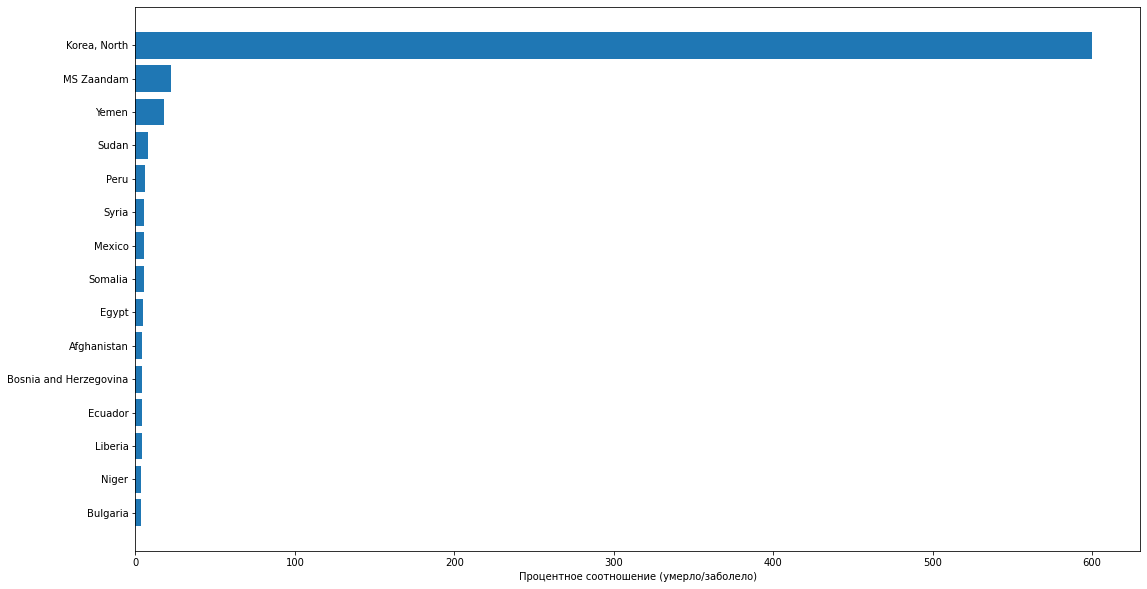

In [ ]:
# СВОЙ ЛЮБОЙ АНАЛИЗ НА ВЫБОР 
# топ 15 стран по количеству смертей от ковида за всё время его существования 
df_death = pd.read_csv(url_death)
df_death_copy = df_death.copy()
df_new_copy=df_new.copy()
result1 = dict()
uniq=df_new_copy["Country/Region"].unique()

for i in uniq:
  buff=df_new_copy.loc[(df_new_copy["Country/Region"] == i)]
  if (buff.shape[0]>1):
    buff=buff[:][:1]
  result1.update({i:buff[buff.columns[-1]][buff.index[0]]})

result2 = dict()
uniq=df_death_copy["Country/Region"].unique()

for i in uniq:
  buff=df_death_copy.loc[(df_death_copy["Country/Region"] == i)]
  if (buff.shape[0]>1):
    buff=buff[:][:1]
  result2.update({i:buff[buff.columns[-1]][buff.index[0]]})

result=dict()

for i in result1:
  result.update({i:result2[i]/result1[i]*100})

result = sorted(result.items(), key=lambda x: x[1])

result = result[-15:]
plt.figure(figsize=(18, 10))
plt.xlabel("Процентное соотношение (умерло/заболело)")
x=[]
y=[]
for i in result:
  x.append(i[0])
  y.append(i[1])
plt.barh(x,y)

На данном графике можно заметить преобладание африканских стран. Это скорее всего связано с низким развитием в области медицины этих стран. Так же нельзя не заметить 600 % смертности у Северной Кореи. Из этого можно сделать вывод, что некоторые страны скрывают информацию о коронавирусе.